In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import os
from sklearn.metrics import f1_score

from fastai import *
from fastai.vision import *

import torch
import torch.nn as nn
import torchvision
import cv2

from tqdm import tqdm
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload

In [2]:
model_path='.'
path='../input/'
train_folder=f'{path}train'
test_folder=f'{path}test'
train_lbl=f'{path}train_labels.csv'
ORG_SIZE=96

bs=64
num_workers=None 
sz=96

In Case I want to run quick tests use a subsample:

In [3]:
df_trn=pd.read_csv(train_lbl)

In [4]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1,
                      max_lighting=0.05, max_warp=0.)

In [5]:
data = ImageDataBunch.from_csv(path,csv_labels=train_lbl,folder='train', ds_tfms=tfms, size=sz, suffix='.tif',test=test_folder,bs=bs);
stats=data.batch_stats()        
data.normalize(stats)

ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
1,0,0,1,0
Path: ../input;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,1,0,0,0
Path: ../input;

Test: LabelList (57458 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: ../input

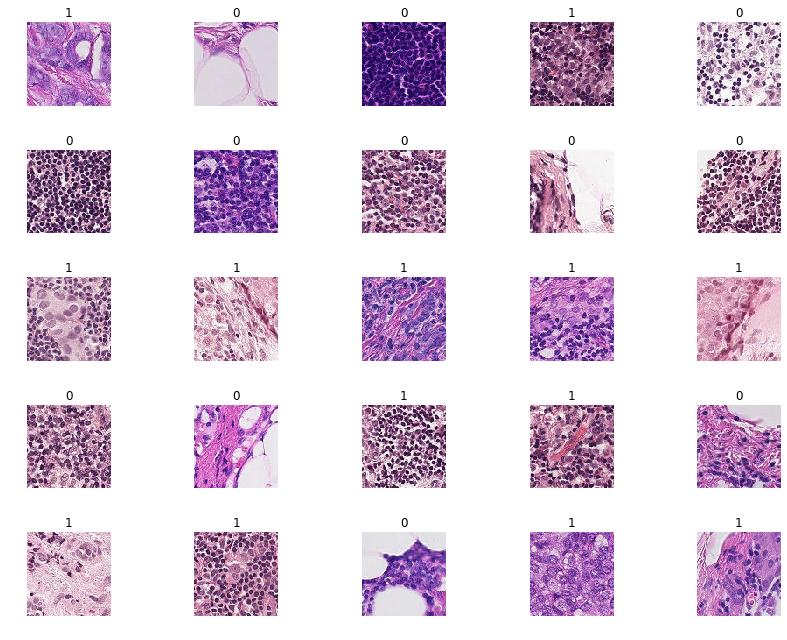

In [6]:
data.show_batch(rows=5, figsize=(12,9))

In [7]:
from sklearn.metrics import roc_auc_score

In [8]:
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [9]:
from torchvision.models import *

In [10]:
learn = create_cnn(
    data,
    densenet201,
    path='.',    
    metrics=[auc_score], 
    ps=0.5
)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /tmp/.cache/torch/checkpoints/densenet201-c1103571.pth
100%|██████████| 81131730/81131730 [00:04<00:00, 19479259.95it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


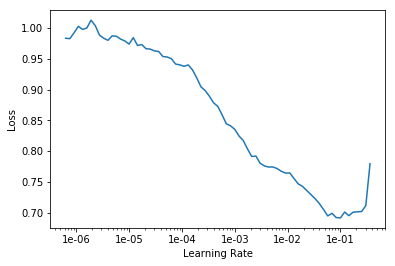

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
lr = 1e-04

epoch,train_loss,valid_loss,auc_score,time
0,0.255599,0.210140,0.965453,11:41


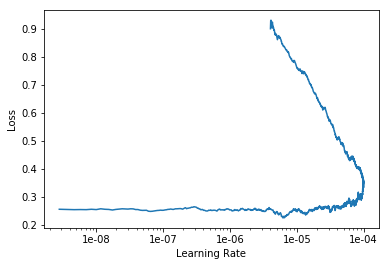

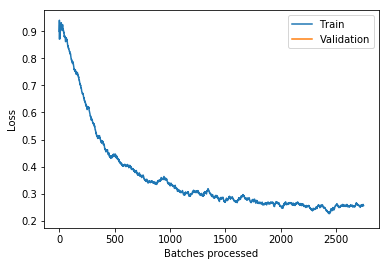

In [13]:
learn.fit_one_cycle(1,lr)
learn.recorder.plot()
learn.recorder.plot_losses()

In [14]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


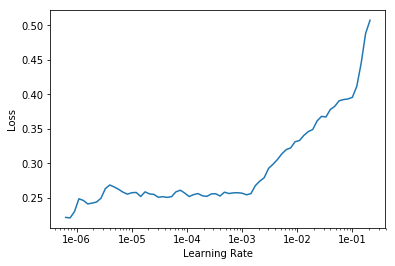

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(10,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,auc_score,time
0,0.170034,0.144983,0.984093,11:40
1,0.138791,0.132482,0.987205,11:37
2,0.115976,0.108818,0.991560,11:39
3,0.100149,0.096823,0.992488,11:39
4,0.095358,0.087398,0.994265,11:38
5,0.083977,0.075396,0.995759,11:45
6,0.069505,0.069396,0.996361,11:39
7,0.048704,0.063614,0.996910,11:41
8,0.043017,0.058916,0.997302,11:46
9,0.034320,0.059614,0.997311,11:43


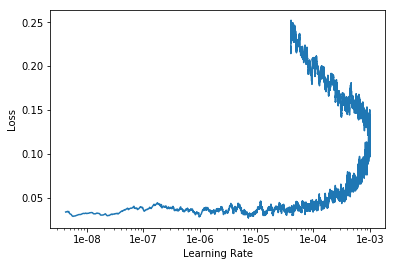

In [17]:
learn.recorder.plot()

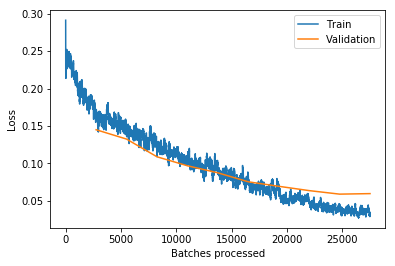

In [18]:
learn.recorder.plot_losses()

In [19]:
preds,y=learn.get_preds()
pred_score=auc_score(preds,y)
pred_score

tensor(0.9973)

In [20]:
preds,y=learn.TTA()
pred_score_tta=auc_score(preds,y)
pred_score_tta

tensor(0.9949)

In [21]:
preds_test,y_test=learn.get_preds(ds_type=DatasetType.Test)

In [22]:
preds_test_tta,y_test_tta=learn.TTA(ds_type=DatasetType.Test)

In [24]:
preds_test_tta

tensor([[9.8732e-01, 1.2678e-02],
        [9.7604e-01, 2.3964e-02],
        [9.5995e-01, 4.0053e-02],
        ...,
        [1.4996e-02, 9.8500e-01],
        [5.9443e-01, 4.0557e-01],
        [9.9931e-01, 6.9061e-04]])

In [25]:
# sub=pd.read_csv(f'KUAN_YING_res.csv').set_index('id')
# sub.head()

In [ ]:
# clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
# fname_cleaned=clean_fname(data.test_ds.items)
# fname_cleaned=fname_cleaned.astype(str)